In [1]:
# Gerekli Kütüphaneleri Yükleyin
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data= pd.read_csv(r"C:\Users\hsynt\Downloads\Selcuk Abi\Selcuk Abi\VeriSeti2.csv")

1249/1249 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 1s 879us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
Holdout Results:
            Accuracy  Precision    Recall  F1-Score   AUC-ROC
No PCA/LDA  0.826761   0.843559  0.852349  0.847931  0.909894
With PCA    0.706865   0.737611  0.749205  0.743363  0.793586
With LDA    0.801841   0.823778  0.827270  0.825520  0.894672
833/833 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
833/833 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
833/833 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
833/833 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
833/833 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
833/833 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step
417/417 ━━━━━━

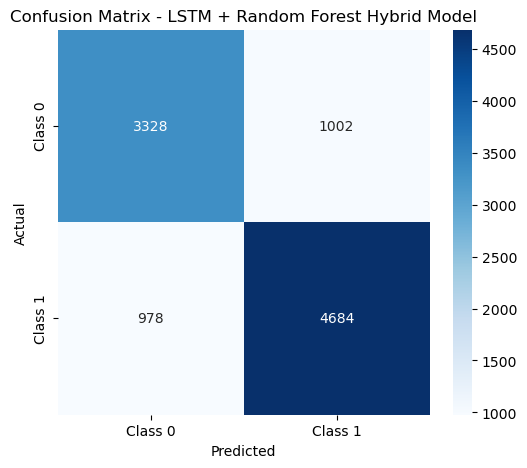

In [3]:

# Özellik ve Hedef Ayrımı
X = data.drop(columns=['Target_10', 'adjclose'])
y = data['Target_10']

# Zaman Serisi Formatına Getirme
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

# LSTM için sekans boyutu
SEQ_LENGTH = 10

# Özellikleri Ölçeklendirme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Sekans Verisi Oluşturma
X_seq = create_sequences(X_scaled, SEQ_LENGTH)
y_seq = y[SEQ_LENGTH:].values

# Eğitim ve Test Setlerine Bölme
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

# LSTM Modelini Tanımlama
def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# PCA ve LDA için Dönüşüm
pca = PCA(n_components=10)
lda = LDA()

# PCA Dönüşüm
X_train_pca = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))

# PCA Çıktısını Doğru Şekillendirme
X_train_pca = X_train_pca.reshape((X_train_pca.shape[0], 1, X_train_pca.shape[1]))
X_test_pca = X_test_pca.reshape((X_test_pca.shape[0], 1, X_test_pca.shape[1]))

# LDA Dönüşüm
X_train_lda = lda.fit_transform(X_train.reshape(X_train.shape[0], -1), y_train)
X_test_lda = lda.transform(X_test.reshape(X_test.shape[0], -1))

# LDA Çıktısını Doğru Şekillendirme
X_train_lda = X_train_lda.reshape((X_train_lda.shape[0], 1, X_train_lda.shape[1]))
X_test_lda = X_test_lda.reshape((X_test_lda.shape[0], 1, X_test_lda.shape[1]))

# Holdout ve K-Fold Sonuçları için Tablolar
holdout_results = {}
kfold_results = []

# Holdout Sonuçları (No PCA/LDA, With PCA, With LDA)
for reduction_type, X_train_set, X_test_set in [
    ("No PCA/LDA", X_train, X_test),
    ("With PCA", X_train_pca, X_test_pca),
    ("With LDA", X_train_lda, X_test_lda)
]:
    # LSTM Modeli
    lstm_model = build_lstm_model(X_train_set.shape[1:])
    lstm_model.fit(X_train_set, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    # Özellik Çıkarma
    X_train_features = lstm_model.predict(X_train_set)
    X_test_features = lstm_model.predict(X_test_set)

    # Random Forest ile Sınıflandırma
    rf_clf = RandomForestClassifier(random_state=42, n_estimators=200)
    rf_clf.fit(X_train_features, y_train)

    # Tahminler
    y_pred = rf_clf.predict(X_test_features)
    y_pred_proba = rf_clf.predict_proba(X_test_features)[:, 1]

    # Performans Metriklerini Hesaplama
    holdout_results[reduction_type] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_pred_proba)
    }

# Holdout Sonuçlarını Yazdırma
print("Holdout Results:")
print(pd.DataFrame(holdout_results).T)

# K-Fold Çapraz Doğrulama
kf = KFold(n_splits=3)
for reduction_type, X_train_set in [
    ("No PCA/LDA", X_train),
    ("With PCA", X_train_pca),
    ("With LDA", X_train_lda)
]:
    for fold, (train_index, test_index) in enumerate(kf.split(X_train_set)):
        X_fold_train, X_fold_test = X_train_set[train_index], X_train_set[test_index]
        y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

        # LSTM Modelini Tanımlama
        lstm_model_fold = build_lstm_model(X_fold_train.shape[1:])
        lstm_model_fold.fit(X_fold_train, y_fold_train, epochs=5, batch_size=32, verbose=0)

        # Özellik Çıkarma
        X_fold_train_features = lstm_model_fold.predict(X_fold_train)
        X_fold_test_features = lstm_model_fold.predict(X_fold_test)

        # Random Forest ile Sınıflandırma
        rf_clf_fold = RandomForestClassifier(random_state=42, n_estimators=200)
        rf_clf_fold.fit(X_fold_train_features, y_fold_train)

        # Tahminler
        y_fold_pred = rf_clf_fold.predict(X_fold_test_features)
        y_fold_proba = rf_clf_fold.predict_proba(X_fold_test_features)[:, 1]

        # Performans Metriklerini Hesaplama
        metrics = {
            "Accuracy": accuracy_score(y_fold_test, y_fold_pred),
            "Precision": precision_score(y_fold_test, y_fold_pred),
            "Recall": recall_score(y_fold_test, y_fold_pred),
            "F1-Score": f1_score(y_fold_test, y_fold_pred),
            "AUC-ROC": roc_auc_score(y_fold_test, y_fold_proba),
            "Reduction": f"{reduction_type} (Fold {fold + 1})"
        }
        kfold_results.append(metrics)

# K-Fold Sonuçlarını DataFrame'e Dönüştürme ve Yazdırma
kfold_df = pd.DataFrame(kfold_results)
print("\nK-Fold Results:")
print(kfold_df)

# Karışıklık Matrisini Görselleştirme
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(y_test, y_pred, "Confusion Matrix - LSTM + Random Forest Hybrid Model")